#  spectra for holo at AuxTel for Scan Pickles data

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date :October 8th 2021


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

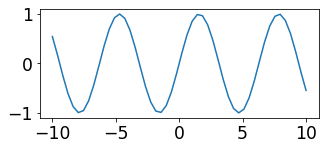

In [2]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from datetime import datetime,date

In [5]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [6]:
string_date

'2022-01-13'

In [7]:
from iminuit import Minuit
import iminuit

In [8]:
iminuit.__version__

'2.7.0'

In [9]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [10]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [11]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

# Function

In [14]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^holo4_003_.*_(.*)_quickLookExp$', filename)
    return m[0]

def file_target(filename):
    m = re.findall('^holo4_003_.*_(.*)_.*_.*_quickLookExp$', filename)
    return m[0]

# Config

In [15]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [16]:
version="v4.0"

# Path

In [17]:
HOSTCC=False

In [18]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/softs/github/lsst/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractorNCSA/"+DATE)

In [19]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractorNCSA/2021-07-07'

In [20]:
!ls /Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractorNCSA/*

/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractorNCSA/2021-07-07:
0234 0242 0250 0258 0266 0274 0282 0290 0298 0306 0323 0331 0339 0347 0355 0363
0235 0243 0251 0259 0267 0275 0283 0291 0299 0309 0324 0332 0340 0348 0356 0364
0236 0244 0252 0260 0268 0276 0284 0292 0300 0317 0325 0333 0341 0349 0357 0365
0237 0245 0253 0261 0269 0277 0285 0293 0301 0318 0326 0334 0342 0350 0358
0238 0246 0254 0262 0270 0278 0286 0294 0302 0319 0327 0335 0343 0351 0359
0239 0247 0255 0263 0271 0279 0287 0295 0303 0320 0328 0336 0344 0352 0360
0240 0248 0256 0264 0272 0280 0288 0296 0304 0321 0329 0337 0345 0353 0361
0241 0249 0257 0265 0273 0281 0289 0297 0305 0322 0330 0338 0346 0354 0362

/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractorNCSA/special:
SpectractorOutputCollectorNCSA_HD160617,2021-07-07-holo.fits


In [21]:

# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

# Logbook for file selection

In [22]:
# Logbook for scan data
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_'+ version+'.csv'

In [23]:
df=pd.read_csv(filename_logbook,index_col=0)

In [24]:
pd.set_option('display.max_rows', None)

In [25]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2000.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2000.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,1900.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,1900.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [26]:
df_good=df[df["quality"]==1]

In [27]:
for spectra_file in df_good["file"]:
    print(spectra_file)

holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
holo4_003_empty_HD160617_20210707_000250_quickLookExp.fi

# Selection of Spectractor output files

In [28]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [29]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)
list_rootnames=[]

for subdir in list_of_files:
    tagname=subdir
    fulldir=os.path.join(path_output_spectractor,subdir)


    NBEXP += 1
    LISTNUM.append(subdir)
    

    if not os.path.isdir(fulldir):
        print("{} is not a directory".format(fulldir))

        NBEXPNODIR+=1

    else:


        print("---------------------------------------------")
        print("{} ({}) is a directory".format(subdir,fulldir))
               
        
        list_of_filesinsubdir=os.listdir(fulldir)
        
        for file in list_of_filesinsubdir:
            
            if file not in ["plots","plots.pdf"]:
                print("\t subdir = {} : file = {} ".format(subdir,file))
            
                rootname=re.findall('^spectraction-(.*).pickle$',file)
            
                print("\t rootname", rootname)
            
                if len(rootname)>0:
                    flag_spectration=True
                    file_spectration=file
                    fullfile_spectration=os.path.join(fulldir,file_spectration)
                    list_rootnames.append(rootname[0])
                else:
                    flag_spectration=False
        
        if not flag_spectration:
            continue
            


        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.stat(fullfile_spectration).st_size>0:
            print(">>>>>>>> file_spectration is not empty : ", fullfile_spectration)
            NBEXPWTHSPEC+=1
            LISTNUMWTHSPECTR.append(tagname)
            flag_empty2 = False
            List_of_spectra_path.append(fullfile_spectration)

        else:
            print("<<<<<<<< file_spectration is empty : ",fullfile_spectration)

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)






LISTNUM=sorted(LISTNUM)
LISTNUMNODIR=sorted(LISTNUMNODIR)
LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractorNCSA/2021-07-07/.DS_Store is not a directory
---------------------------------------------
0234 (/Users/dagoret/DATA/AuxTelData2021/holo/OutputSpectractorNCSA/2021-07-07/0234) is a directory
	 subdir = 0234 : file = spectraction-2021-07-07-0234.pickle 
	 rootname ['2021-07-07-0234']


NameError: name 'dir_plots' is not defined

In [ ]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

In [ ]:
Selected_Files=List_of_spectra_path[0]
pickle.load(Selected_Files)

In [ ]:
infile = open(Selected_Files)
pickle.load(infile)
infile.close()


In [ ]:
with open(Selected_Files, 'wb') as f:
    pickle.dump(some_obj, f)

In [ ]:
import pandas as pd

object = pd.read_pickle(Selected_Files)

In [ ]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [ ]:
all_files_spectra[:3]

In [ ]:
all_files_spectrogram[:3]

In [ ]:
all_files_lines[:3]

In [ ]:
all_files_table[:3] 

# Selection of good spectra

In [ ]:
all_good_spectra_spectrum_files = all_files_spectra

In [ ]:
parameters.DISPLAY=False

infos = []

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    
   
    
    
                   
    
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

# Selection of the spectrum

In [ ]:
IDXSEL=30

In [ ]:
all_good_spectra_spectrum_files[IDXSEL]

In [ ]:
fullfilename_SEL=all_good_spectra_spectrum_files[IDXSEL]
fullfilename_spectrogram_SEL=fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL=fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL=fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [ ]:
filename_SEL = os.path.basename(fullfilename_SEL)
filename_spectrogram_SEL = os.path.basename(fullfilename_spectrogram_SEL)
filename_lines_SEL = os.path.basename(fullfilename_lines_SEL)
filename_table_SEL = os.path.basename(fullfilename_table_SEL)

## Spectrum

In [ ]:
spectrum_hdu=fits.open(fullfilename_SEL)

In [ ]:
spectrum_hdu.info()

In [ ]:
spectrum_hdu[0].header

In [ ]:
fig=plt.figure(figsize=(16,10))

# Spectrum
ax=fig.add_subplot(4,1,1)
x=spectrum_hdu[0].data[0,:]
y=spectrum_hdu[0].data[1,:]
yerr=spectrum_hdu[0].data[1,:]
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=0.5,color="r",ecolor="gray")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("spectrum")
ax.grid()

# Covariance

from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize,LogStretch)

ax=fig.add_subplot(4,1,2)
img=spectrum_hdu[1].data

# Create an ImageNormalize object
norm = ImageNormalize(img, interval=MinMaxInterval(),stretch=LogStretch())


#ax.imshow(img,origin="lower",norm=LogNorm())
ax.imshow(img,origin="lower",norm=norm)
ax.grid()
ax.set_title("Covariance")


# Order 2
ax=fig.add_subplot(4,1,3)
x=spectrum_hdu[2].data[0,:]
y=spectrum_hdu[2].data[1,:]
yerr=spectrum_hdu[2].data[1,:]
ax.errorbar(x, y, yerr=yerr, fmt='o',markersize=0.5,color="r",ecolor="gray")
ax.set_xlabel("$\lambda$ (nm)")
ax.set_title("Order 2")
ax.grid()

# ORDER0  
ax=fig.add_subplot(4,1,4)
img=spectrum_hdu[3].data
ax.imshow(img,origin="lower",norm=LogNorm())
ax.grid()
ax.set_title("Order 0")

plt.tight_layout()

In [ ]:
fullfilename_spectrogram_SEL

## Spectrogram

In [ ]:
spectrogram_hdu=fits.open(fullfilename_spectrogram_SEL)

In [ ]:
spectrogram_hdu.info()

## header

In [ ]:
header=spectrogram_hdu[0].header
header

In [ ]:
spectrogram_image= spectrogram_hdu[0].data

## Lines

In [ ]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [ ]:
df_lines

In [ ]:
df_lines.columns

In [ ]:
df_lines.index[0]

In [ ]:
idx=0
all_lines = []
for index, row in df_lines.iterrows():
    print(df_lines.index[idx], row['Tabulated'])
    line = Line(row['Tabulated'], label=df_lines.index[idx], atmospheric=False , emission=True, label_pos=[0, 0.8])
    if row['SNR']>5:
        all_lines.append(line)
    idx+=1

In [ ]:
lines_collection=Lines(all_lines)

In [ ]:
df_table=pd.read_csv(fullfilename_table_SEL)

In [ ]:
df_table.head()

In [ ]:
fig = plt.figure(figsize=(18,10))
ax=fig.add_subplot(2,1,1)
ax.plot(s.lambdas,s.data,"r-")
thetitle=str(IDXSEL)+") "+ filename_SEL
ax.set_title(thetitle)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux")
ax.grid()
ax.set_ylim(0,2e-12)
lines_collection.plot_atomic_lines(ax, color_atomic='g', color_atmospheric='b', fontsize=20, force=True)
ax=fig.add_subplot(2,1,2)
ax.imshow(spectrogram_image,origin="lower",norm=LogNorm())
ax.grid()
ax.set_xlabel("pixel")
plt.show()

## Tables

In [ ]:
df_table=pd.read_csv(fullfilename_table_SEL,index_col=0)

In [ ]:
df_table.head()

In [ ]:
# df_table.index.get_level_values

In [ ]:
# df_table.index.get_level_values

In [ ]:
df_table['wl'] = df_table.index

In [ ]:
#df_table.reset_index()

In [ ]:
df_table.head()

In [ ]:
df_table.columns

In [ ]:
fig=plt.figure(figsize=(16,30))

idx=0
column_names=df_table.columns
NN=len(column_names)

# Dx
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel(column_names[idx-1])
ax.grid()
# Dy
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_disp_axis
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# flux_sum
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# flux_integral
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

#flux_err
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# fwhm

idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_fwhm_sup
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# Dy_fwhm_inf
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# amplitude 
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()


# x_c
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# y_c
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# gamma
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()


# alpha 
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()

# saturation
idx+=1
ax=fig.add_subplot(NN,1,idx)
ax.plot(df_table["wl"],df_table[column_names[idx-1]],"b-")
ax.set_xlabel("$\\lambda$")
ax.set_ylabel(column_names[idx-1])
ax.grid()




# Atmospheric conditions

In [ ]:
df_infos=pd.DataFrame(infos,columns=["idx","date_obs","airmass","temperature","pressure","humidity"])

In [ ]:
df_infos.set_index('idx',inplace=True)

In [ ]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [ ]:
all_reftime=np.array(all_reftime)

In [ ]:
df_infos["reftime"]=all_reftime

In [ ]:
df_infos["eqw_h2o"] = np.nan
df_infos["eqw_o2"] = np.nan
df_infos["eqw_o2_spec"] = np.nan

In [ ]:
df_infos

# STOP HERE

In [ ]:
assert False

# Selection of spectra and equivalent width calculation

In [ ]:
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()  # for getting units on the axes below  

In [ ]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [ ]:
IDXSEL=0
filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
filename_lines_SEL=filename_SEL.replace("_spectrum.fits","_lines.csv")
filename_table_SEL=filename_SEL.replace("_spectrum.fits","_table.csv")
fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
fullfilename_lines_SEL = fullfilename_SEL.replace("_spectrum.fits","_lines.csv")
fullfilename_table_SEL = fullfilename_SEL.replace("_spectrum.fits","_table.csv")

In [ ]:
fullfilename_table_SEL

In [ ]:
thetitle=str(IDXSEL)+") "+filename_SEL

In [ ]:
thetitle

In [ ]:
fullfilename_SEL

## Load spectrum and Spectrogram

In [ ]:
s=Spectrum(fullfilename_SEL, config=config)
s.load_spectrogram(fullfilename_spectrogram_SEL) 

In [ ]:
df_lines=pd.read_csv(fullfilename_lines_SEL,index_col=0)

In [ ]:
df_lines

In [ ]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [ ]:
s.lines = lines

In [ ]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [ ]:
# global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

In [ ]:
fig = plt.figure(figsize=(18,10))
plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
lines.plot_detected_lines(plt.gca())
thetitle=str(IDXSEL)+") "+ filename_SEL
plt.title(thetitle)
plt.show()

In [ ]:
# lines.print_detected_lines()

In [ ]:
alert False

## with specutils

### Convert in specutils units

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

## Equivalent width calculation with Automatic line plot

In [ ]:
def ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True)
    
    - input :
    
    
    - output :
    
    """
            
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        
    return eqw1.value,eqw2.value     

In [ ]:
def ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=None,ax2=None):
    """
    
    ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline)
    
    - input :
    
    
    - output :
    
    """
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
         
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
       
    eqw10=equivalent_width(cont_norm_spec, regions=line_region).value 
    eqw20=equivalent_width(cont_norm_spec, regions=sub_region).value 
       
    # Bootstrap
    
    
    eqw1_set=np.zeros(NN)
    eqw2_set=np.zeros(NN)
    size=len(specerr.flux)
    
    # loop on trials 
    for idx in np.arange(NN):
        
        # random generator for errors
        s = np.random.normal(0, 1, size)
        
        # new flux
        newspec = Spectrum1D(spectral_axis=spec.spectral_axis, flux=spec.flux+specerr.flux*s)
              
    
        # region where one extract the spectrum
        sub_spectrum = extract_region(newspec, sub_region)
    
        # initialisaition of linear model
        g_init = models.Linear1D(slope=0,intercept=1e-12)
    
        # fit on sub-spectrum
        g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
        # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
        g2_fit = fit_continuum(newspec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
        y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
        y_continuum_fitted2 = g2_fit(newspec.spectral_axis)
    
        # normalize the spectrum
        cont_norm_spec = newspec/ y_continuum_fitted2 
    
    
        eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
        eqw2=equivalent_width(cont_norm_spec, regions=sub_region) 
        
        
        eqw1_set[idx]=eqw1.value
        eqw2_set[idx]=eqw2.value
        
     
    eqw1_std=eqw1_set.std()
    eqw2_std=eqw2_set.std()
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw10,eqw1_std)
        eqw_str2="$Eqw_2$ = {:2.2f} $\pm$ {:2.2f} $\AA$ ".format(eqw20,eqw2_std)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline,color='r')
        ax1.axvline(wlmaxline,color="r")
        ax1.axvline(wlmin,color='g')
        ax1.axvline(wlmax,color="g")
        ax1.set_ylim(YMIN,YMAX)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline,color='r')
        ax2.axvline(wlmaxline,color="r")
        ax2.axvline(wlmin,color='g')
        ax2.axvline(wlmax,color="g")
        ax2.set_ylim(0,2)
        ax2.text(0.05, 0.95, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
               
        
    return eqw10,eqw20,eqw1_set,eqw2_set     

### The original spectrum

#### O2 line

In [ ]:
wlmin=10*(O2_1.wavelength-30)*u.AA
wlmax=10*(O2_1.wavelength+30)*u.AA
wlminline=10*(O2_1.wavelength-10)*u.AA
wlmaxline=10*(O2_1.wavelength+10)*u.AA

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color="b");
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

### H2O line

In [ ]:
wlmin=10*(H2O_1.wavelength-30)*u.AA
wlmax=10*(H2O_2.wavelength+30)*u.AA
wlminline=10*(H2O_1.wavelength-12)*u.AA
wlmaxline=10*(H2O_2.wavelength+10)*u.AA

In [ ]:
lamb = 10*s.lambdas * u.AA 
flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10. 
fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=30,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(thetitle)

In [ ]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(eq1_set,bins=50,histtype='step',color='b');
ax1.axvline(eqw10,color='r')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(eq2_set,bins=50,histtype='step',color='b');
ax2.axvline(eqw20,color='r')
plt.suptitle(thetitle)

# Loop on spectra with Spectractor

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,7):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    #wlidx=np.where(np.logical_and( s.lambdas>=WLMIN, s.lambdas<=WLMAX))[0]
    #print(wlidx)
    #wl=s.lambdas[wlidx]
    
    #specify the lines  
    lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)
    s.lines = lines
    
    global_chisq = detect_lines(lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)
    
    print(IDXSEL,") ",filename_SEL)
    thetitle=str(IDXSEL)+") "+filename_SEL
    
    fig = plt.figure(figsize=(10,5))
    plot_spectrum_simple(plt.gca(), s.lambdas, s.data, s.err)
    lines.plot_detected_lines(plt.gca())
    plt.title(thetitle)
    plt.show()
    
    print(lines.print_detected_lines())
    print(lines.print_detected_lines()[0]["Eqwidth_data"])
    df_infos.at[IDXSEL,"eqw_o2_spec"] = lines.print_detected_lines()[0]["Eqwidth_data"]*10.
    
    

In [ ]:
print(lines.print_detected_lines())

In [ ]:
type(lines.print_detected_lines())

In [ ]:
print(lines.print_detected_lines()[0]["Eqwidth_data"])

In [ ]:
df_infos

# Loop on spectrum, compute O2 line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):

    
    
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    
    print(IDXSEL,") ",filename_SEL)
    
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # O2 line
    wlmin=10*(O2_1.wavelength-30)*u.AA
    wlmax=10*(O2_1.wavelength+30)*u.AA
    wlminline=10*(O2_1.wavelength-10)*u.AA
    wlmaxline=10*(O2_1.wavelength+10)*u.AA
    
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    #eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw10)
    
    df_infos.at[IDXSEL,"eqw_o2"] =  eqw10

# Loop on spectrum, compute H2O line equivalent width with specutils 

In [ ]:
WLMIN=300
WLMAX=1000
lambdas = np.arange(WLMIN,WLMAX,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)
parameters.DISPLAY=False


for IDXSEL in np.arange(0,8):
    filename_SEL=all_good_spectra_spectrum_files[IDXSEL]
    filename_spectrogram_SEL=filename_SEL.replace("_spectrum","_spectrogram")
    fullfilename_SEL = os.path.join(dir_spectra,filename_SEL)
    fullfilename_spectrogram_SEL = fullfilename_SEL.replace("_spectrum","_spectrogram")
    
    # load the spectrum
    s=Spectrum(fullfilename_SEL, config=config)
    s.load_spectrogram(fullfilename_spectrogram_SEL) 
    
    
    lamb = 10*s.lambdas * u.AA 
    flux = s.data * u.Unit('erg cm-2 s-1 AA-1')/10 
    spec = Spectrum1D(spectral_axis=lamb, flux=flux) 
    fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
    specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)
    
    # H2O line
    
    wlmin=10*(H2O_1.wavelength-30)*u.AA
    wlmax=10*(H2O_2.wavelength+30)*u.AA
    wlminline=10*(H2O_1.wavelength-12)*u.AA
    wlmaxline=10*(H2O_2.wavelength+10)*u.AA
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    eqw1,eqw2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
    #eqw10,eqw20,eq1_set,eq2_set=ComputeEquivWidth_bootstrap(spec,specerr,wlmin,wlmax,wlminline,wlmaxline,NN=20,flag_plot=True,ax1=ax1,ax2=ax2)
    thetitle=str(IDXSEL)+") "+filename_SEL
    plt.suptitle(thetitle,y=1.01)
    plt.show() 
    
    print(IDXSEL,") eqw_O2=",eqw1)
    
    df_infos.at[IDXSEL,"eqw_h2o"] =  eqw1

In [ ]:
df_infos

In [ ]:
df_infos.to_csv("eqw.csv")

In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['date_obs'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass")
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")

In [ ]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
df_infos.plot(ax=ax,x="date_obs", y=["eqw_o2","eqw_h2o"],color=["r","b"],marker="o");
#plt.gcf().autofmt_xdate(rotation=90) 
ax.xaxis.set_tick_params(rotation=90)
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax.set_yscale("log")

ax2 = ax.twinx()
df_infos.plot(ax=ax2,x="date_obs", y="airmass",color=["g"],marker="o",lw=0);
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax2.set_ylim(1,2)
ax2.xaxis.set_tick_params(rotation=90)
ax.set_title("Equivalent Widths vs date")


In [ ]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['reftime'], df_infos['eqw_o2'],marker="o",color="red",label="$eqw(O_2)$");
ax.plot(df_infos['reftime'], df_infos['eqw_h2o'],marker="o",color="blue",label="$eqw(H_2O)$");
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.legend(loc="upper right")
ax.set_ylabel("Equivalent Width $\AA$")
ax2 = ax.twinx()
ax2.plot(df_infos['reftime'], df_infos['airmass'],linestyle='dotted', marker='.',color="green",label="airmass",lw=0)
ax2.set_ylim(1,1.5)
ax2.legend(loc="upper left")
ax2.set_ylabel("airmass")
ax.set_title("Equivalent Widths vs date")